In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Baseline Model

## Importing Dependencies

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import collections, random, re
from collections import Counter
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from skimage import io
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import sentence_bleu
import tensorflow as tf
from tensorflow.python.keras import Model
from tqdm import tqdm
import os
import nltk
%matplotlib inline

In [4]:
print(tf. __version__)

2.12.0


In [5]:
images='/content/gdrive/MyDrive/Flicker8k_Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


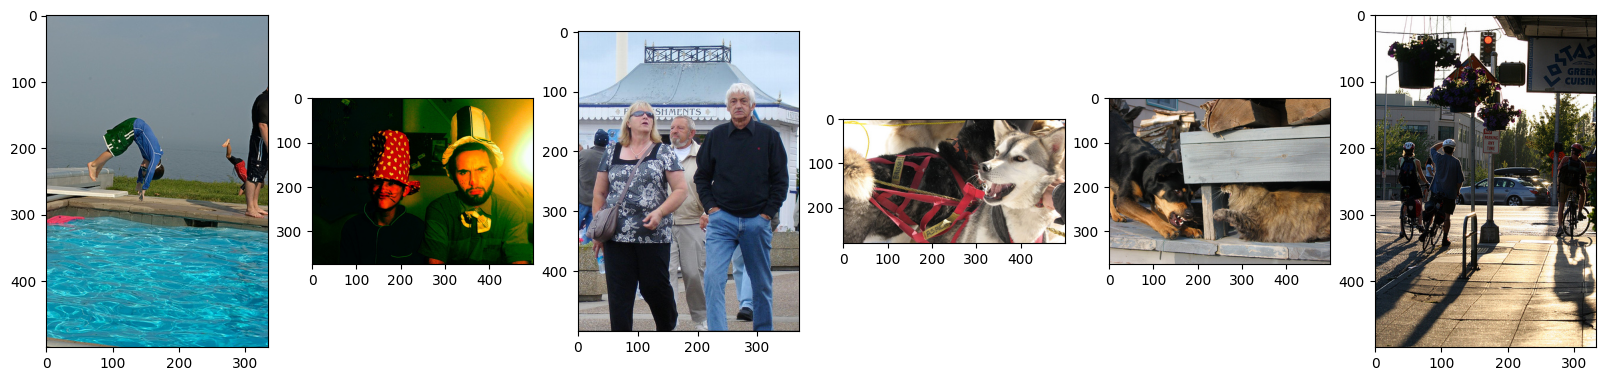

In [7]:
figure, axes = plt.subplots(1, 6)
figure.set_figwidth(20)

for ax,image in zip(axes, all_imgs[0:6]):
    ax.imshow(io.imread(image), cmap=None)

## Caption Pre-Processing

In [8]:
text_file = '/content/gdrive/MyDrive/Flickr8k_text/Flickr8k.token.txt'

def load_doc(filename):
    with open(filename, 'r') as ff:
        next(ff) # to skip the header
        text = ff.read()
    return text

doc = load_doc(text_file)
print(doc[:300])

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a woode


Generating a list storing the images and their corresponding captions

In [9]:
path_of_images='/content/gdrive/MyDrive/Flicker8k_Images/'
list_of_images_and_captions = []
for i in doc.split('\n'):
    image_id = i.split("\t",maxsplit=1)[0].split("#")[0]
    if (len(i.split("#", maxsplit=1)) != 2):
        print(i)
    if os.path.exists(path_of_images + "/" + str(image_id)):
        list_of_images_and_captions.append(i.split("#", maxsplit=1))

Removing the NULL entry

In [10]:
print(len(list_of_images_and_captions))
new_list = []
for i in list_of_images_and_captions:
    if len(i) != 2:
        print(i)
    else:
        new_list.append([i[0], str(i[1].split('\t')[1])])
print(len(new_list))
list_of_images_and_captions = new_list

40455
['']
40454


In [ ]:
all_img_id= [img[0] for img in list_of_images_and_captions if img[0]] #store all the image id here
all_img_vector= [path_of_images+img[0] for img in list_of_images_and_captions if img[0]] #store all the image path here
annotations= [img[1] for img in list_of_images_and_captions if img[0]] #store all the captions here
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 

In [13]:
image_to_captions_dictionary = {}
for i in range(0, len(df)):
    if image_to_captions_dictionary.get(df['ID'][i]) == None:
        image_to_captions_dictionary[df['ID'][i]] = df['Captions'][i]
    else:
        image_to_captions_dictionary[df['ID'][i]] += (" " + df['Captions'][i])

In [15]:
annotations= ['<start> '+ annoted_caption + ' <end>' for annoted_caption in df.Captions] 
annotations_new = ['<start> '+ annoted_caption[1] + ' <end>' for annoted_caption in image_to_captions_dictionary.items()]
all_img_path= df.Path.unique().tolist() 

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40454
Total images present in the dataset: 8091


In [16]:
vocabulary= [] 
for cap in df.Captions.values:
    list_of_words = list(filter(lambda w: len(w)>0, re.split('\W+',cap.lower())))
    for word in list_of_words:
        vocabulary.append(word)

val_count = Counter(vocabulary) 

In [17]:
def show_count(axs, space=.01):
    def _single(ax):
      for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
        value = '{:.1f}'.format(p.get_height())
        ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [19]:
max_words = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=max_words,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token="<unk>")

tokenizer.fit_on_texts(annotations)
train_seq = tokenizer.texts_to_sequences(annotations)

In [20]:
tokenizer.word_index['<pad>'] = 0 
tokenizer.index_word[0] = '<pad>'

word_to_index_mapping = tokenizer.word_index
index_to_word_mapping = tokenizer.index_word

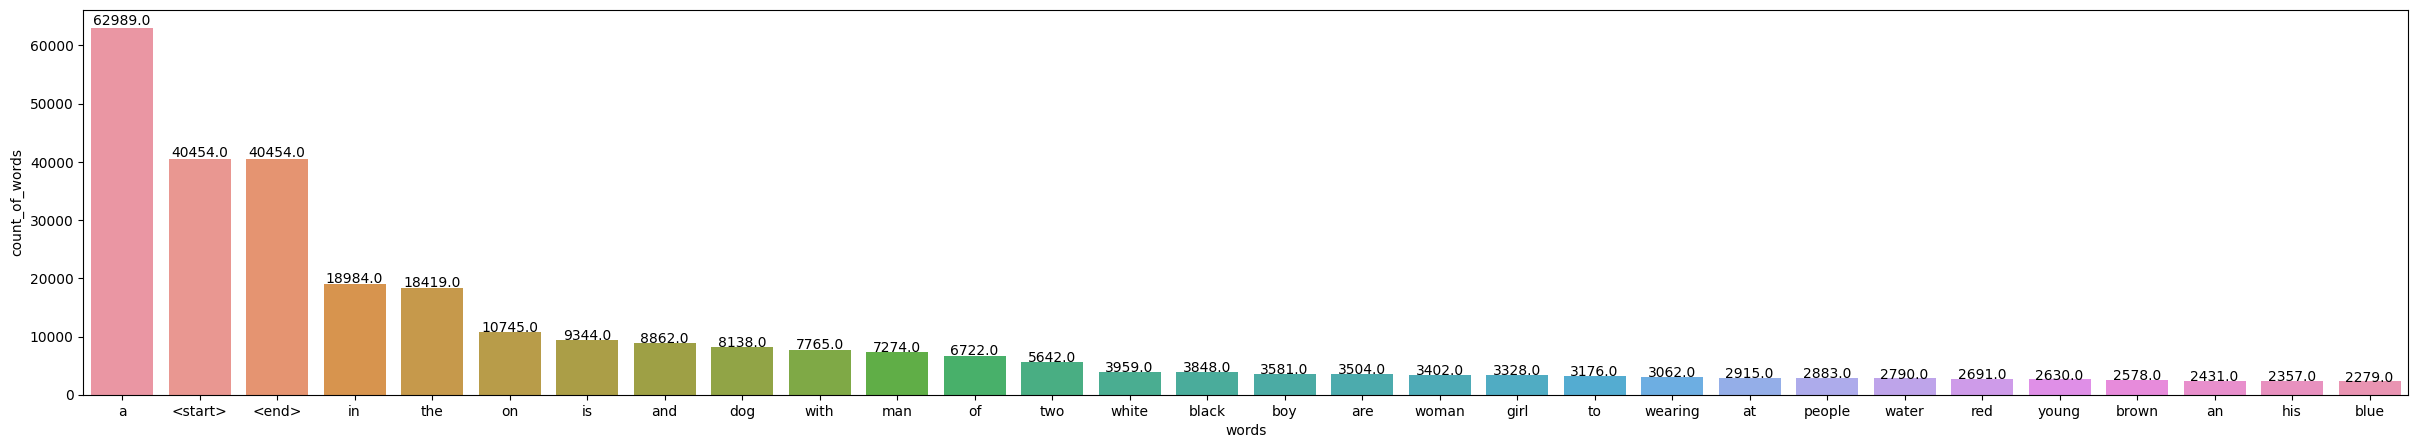

In [22]:
tokenizer_wc = Counter(tokenizer.word_counts)
top30_tokenizer_wc_df = pd.DataFrame(tokenizer_wc.most_common(30), columns=['words', 'count_of_words'])
plt.figure(figsize=(30,5))
top30_plot = sns.barplot(x='words', y='count_of_words', data=top30_tokenizer_wc_df)
show_count(top30_plot)

In [23]:
max_seq_len = max([len(x) for x in train_seq]) 
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(
    train_seq,
    maxlen=max_seq_len,
    dtype='int32',
    padding='post',
    truncating='post',
    value=0
)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40454, 39)


In [24]:
print(cap_vector[0])
print(annotations[0])

cur_ptr = 0
image_to_cap_vector_dicitionary = {}
for key, value in image_to_captions_dictionary.items():
    image_to_cap_vector_dicitionary[key] = cap_vector[cur_ptr]
    cur_ptr += 1
print(len(image_to_cap_vector_dicitionary)) 

print(len(cap_vector))

[  3   2  20 317  65   2 197 118   4   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
<start> A girl going into a wooden building . <end>
8091
40454


## Image Pre-Processing

In [25]:
image_dataset = tf.data.Dataset.from_tensor_slices(all_img_path)

In [26]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    decoded_image = tf.io.decode_jpeg(image, channels=3)
    resized_image = tf.image.resize(decoded_image, (299, 299)) 
    preprocessed_image = tf.keras.applications.inception_v3.preprocess_input(resized_image) 
    return preprocessed_image, image_path

In [27]:
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
image_dataset = image_dataset.batch(64,drop_remainder=False)

In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=True,weights='imagenet') 
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

96112376/96112376 [==============================] - 3s 0us/step


Storing the Embeddings in a dictionary

In [29]:
image_dict_features={}
for img, img_path in tqdm(image_dataset):
    img_features = image_features_extract_model(img)
    for batch_feature, path in zip(img_features, img_path):
        path_feat = path.numpy().decode("utf-8")
        image_dict_features[path_feat] =  batch_feature.numpy()

100%|██████████| 127/127 [03:13<00:00,  1.52s/it]


In [30]:
all_img_path= df.Path.tolist()

Generating the train, test, validation splits for captions and images

In [31]:
train_file = '/content/gdrive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt'
with open(train_file, 'r') as f:
    train_file_names = f.read().splitlines()
test_file = '/content/gdrive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt'
with open(test_file, 'r') as f:
    test_file_names = f.read().splitlines()
val_file = '/content/gdrive/MyDrive/Flickr8k_text/Flickr_8k.valImages.txt'
with open(val_file, 'r') as f:
    val_file_names = f.read().splitlines()
path_train = ['/content/gdrive/MyDrive/Flicker8k_Images/' + str(img_path) for img_path in train_file_names]
cap_train = [image_to_cap_vector_dicitionary[img_path] for img_path in train_file_names]
path_test = ['/content/gdrive/MyDrive/Flicker8k_Images/' + str(img_path) for img_path in test_file_names]
cap_test = [image_to_cap_vector_dicitionary[img_path] for img_path in test_file_names]
path_val = ['/content/gdrive/MyDrive/Flicker8k_Images/' + str(img_path) for img_path in val_file_names]
cap_val = [image_to_cap_vector_dicitionary[img_path] for img_path in val_file_names]
print(len(cap_train))
print(len(path_train))
print(len(cap_val))
print(len(path_val))
print(len(cap_test))
print(len(path_test))

6000
6000
1000
1000
1000
1000


In [32]:
path_train_new = []
cap_train_new = []
for i in range(len(df)):
    if df['Path'][i] in path_train:
        path_train_new.append(df['Path'][i])
        cap_train_new.append(cap_vector[i])
    
path_test_new = []
cap_test_new = []
for i in range(len(df)):
    if df['Path'][i] in path_test:
        path_test_new.append(df['Path'][i])
        cap_test_new.append(cap_vector[i])

path_val_new = []
cap_val_new = []
for i in range(len(df)):
    if df['Path'][i] in path_val:
        path_val_new.append(df['Path'][i])
        cap_val_new.append(cap_vector[i])

path_train = path_train_new
cap_train = cap_train_new
path_test = path_test_new
cap_test= cap_test_new
path_val = path_val_new
cap_val = cap_val_new
print(len(path_train))
print(len(cap_train))
print(len(path_test))
print(len(cap_test))
print(len(path_val))
print(len(cap_val))

29999
29999
5000
5000
5000
5000


In [33]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 29999
Testing data for images: 5000
Training data for Captions: 29999
Testing data for Captions: 5000


## Model Definition

In [34]:
def map_func(img,cap):
	img_tensor = image_dict_features[img.decode('utf-8')]
	return img_tensor, cap

In [35]:
def gen_dataset(img, cap, batch=64, buffer=1000):
	dataset_from_tensor = tf.data.Dataset.from_tensor_slices((img,cap))
	dataset_from_tensor = dataset_from_tensor.map(lambda x, y: tf.numpy_function(map_func, [x, y], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
	dataset_from_tensor = dataset_from_tensor.shuffle(buffer)
	dataset_from_tensor = dataset_from_tensor.batch(batch, drop_remainder=False)
	dataset_from_tensor = dataset_from_tensor.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
		
	return dataset_from_tensor

In [36]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [38]:
embedding_dim = 256 
units = 512
vocab_size = 5001 
train_num_steps = len(path_train) // 64 
test_num_steps = len(path_test) // 64 
attention_features_shape = batch_feature.shape[0] 

In [39]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim,activation='relu') 
        
    def call(self, features):
        features = self.dense(features) 
        return features

In [40]:
encoder=Encoder(embedding_dim) 

In [42]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=False) 
        self.lstm = tf.keras.layers.LSTM(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform') 
        self.d1 = tf.keras.layers.Dense(self.units) 
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        embed = self.embed(x)
        embed = tf.concat([tf.expand_dims(features,1), embed], axis=-1) 
        output,state = self.lstm(embed) 
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output) 
        
        return output,state
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [43]:
decoder=Decoder(embedding_dim, units, vocab_size) 

## Training

In [45]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE) 

In [46]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0)) 
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype) 
    loss_ *= mask 

    return tf.reduce_mean(loss_) 

In [47]:
checkpoint_path = "./checkpoint/" 
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5) 

In [48]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [49]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        encoded_data = encoder(img_tensor)
        for x in range(1,target.shape[1]):
            pred, hidden = decoder(dec_input, encoded_data, hidden)
            loss += loss_function(target[:, x], pred)
            dec_input = tf.expand_dims(target[:,x], 1)
    avg_loss = (loss/int(target.shape[1])) 
    all_trainable_vars = encoder.trainable_variables + decoder.trainable_variables 
    gradients = tape.gradient(loss,all_trainable_vars) 
    optimizer.apply_gradients(zip(gradients, all_trainable_vars))
        
    return loss, avg_loss

In [50]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        encoder_output = encoder(img_tensor)
        for x in range(1,target.shape[1]):
            pred, hidden, _ = decoder(dec_input, encoder_output, hidden)
            loss += loss_function(target[:,x], pred)
            predicted_id = tf.argmax(pred,1)
            dec_input = tf.expand_dims(predicted_id, 1)

        avg_loss = (loss/int(target.shape[1]))

    return loss, avg_loss

In [51]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss = total_loss / train_num_steps
    
    return avg_test_loss

In [52]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.280, & test loss is 0.183
Time taken for 1 epoch 140.29951167106628 sec

Test loss has been reduced from 100.000 to 0.183


 13%|█▎        | 2/15 [02:55<16:57, 78.30s/it] 

For epoch: 2, the train loss is 1.013, & test loss is 0.164
Time taken for 1 epoch 34.56865119934082 sec

Test loss has been reduced from 0.183 to 0.164


 20%|██        | 3/15 [03:28<11:32, 57.68s/it]

For epoch: 3, the train loss is 0.936, & test loss is 0.154
Time taken for 1 epoch 32.97111940383911 sec

Test loss has been reduced from 0.164 to 0.154


 27%|██▋       | 4/15 [04:02<08:50, 48.22s/it]

For epoch: 4, the train loss is 0.886, & test loss is 0.147
Time taken for 1 epoch 33.529924154281616 sec

Test loss has been reduced from 0.154 to 0.147


 33%|███▎      | 5/15 [04:34<07:06, 42.68s/it]

For epoch: 5, the train loss is 0.848, & test loss is 0.141
Time taken for 1 epoch 32.68315505981445 sec

Test loss has been reduced from 0.147 to 0.141


 40%|████      | 6/15 [05:08<05:55, 39.54s/it]

For epoch: 6, the train loss is 0.813, & test loss is 0.135
Time taken for 1 epoch 33.24058938026428 sec

Test loss has been reduced from 0.141 to 0.135


 47%|████▋     | 7/15 [05:40<04:57, 37.17s/it]

For epoch: 7, the train loss is 0.782, & test loss is 0.130
Time taken for 1 epoch 32.12522268295288 sec

Test loss has been reduced from 0.135 to 0.130


 53%|█████▎    | 8/15 [06:14<04:12, 36.05s/it]

For epoch: 8, the train loss is 0.753, & test loss is 0.126
Time taken for 1 epoch 33.45172476768494 sec

Test loss has been reduced from 0.130 to 0.126


 60%|██████    | 9/15 [06:46<03:29, 34.85s/it]

For epoch: 9, the train loss is 0.727, & test loss is 0.121
Time taken for 1 epoch 32.018895626068115 sec

Test loss has been reduced from 0.126 to 0.121
For epoch: 10, the train loss is 0.703, & test loss is 0.117
Time taken for 1 epoch 32.19223403930664 sec

Test loss has been reduced from 0.121 to 0.117


 73%|███████▎  | 11/15 [07:51<02:14, 33.70s/it]

For epoch: 11, the train loss is 0.680, & test loss is 0.114
Time taken for 1 epoch 32.5803108215332 sec

Test loss has been reduced from 0.117 to 0.114


 80%|████████  | 12/15 [08:23<01:39, 33.20s/it]

For epoch: 12, the train loss is 0.660, & test loss is 0.111
Time taken for 1 epoch 31.885490894317627 sec

Test loss has been reduced from 0.114 to 0.111


 87%|████████▋ | 13/15 [08:57<01:06, 33.21s/it]

For epoch: 13, the train loss is 0.640, & test loss is 0.107
Time taken for 1 epoch 33.024614095687866 sec

Test loss has been reduced from 0.111 to 0.107


 93%|█████████▎| 14/15 [09:29<00:32, 32.89s/it]

For epoch: 14, the train loss is 0.623, & test loss is 0.104
Time taken for 1 epoch 31.991620302200317 sec

Test loss has been reduced from 0.107 to 0.104
For epoch: 15, the train loss is 0.607, & test loss is 0.102
Time taken for 1 epoch 33.21573877334595 sec

Test loss has been reduced from 0.104 to 0.102


100%|██████████| 15/15 [10:02<00:00, 40.18s/it]


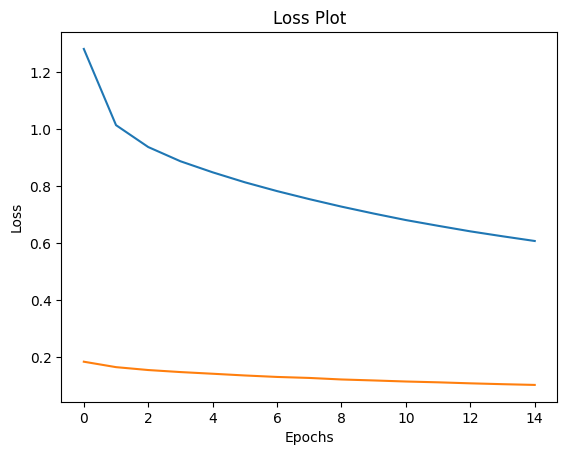

In [53]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluation of Model, including BLEU and METEOR

In [54]:
def evaluate(image):
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input)

    features = encoder(img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_seq_len):
        predictions, hidden = decoder(dec_input, features, hidden) 

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() 
        
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, predictions


In [56]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...


BELU score: 26.31578947368421
METEOR score:  73.77691982867829
Real Caption: a soccer player tries to kick the ball in the goal
Prediction Caption: a goal attempt during a goal attempt during a soccer player just kicked the goal attempt during a ball in red soccer player tries to enter a goal attempt during a game the goal attempt during a goal


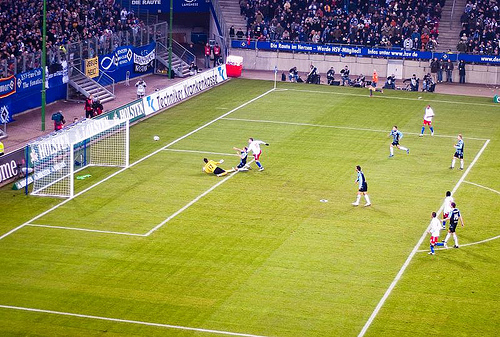

In [58]:
import nltk
nltk.download('wordnet')
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
meteor_score = nltk.translate.meteor_score.meteor_score(reference, candidate)
print(f"BELU score: {score*100}")
print("METEOR score: ", meteor_score*100)

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)

Image.open(test_image)

In [59]:
avg_bleu = 0
avg_meteor = 0
num_test_cases = len(path_test)
for i in tqdm(range(len(path_test))):
    test_image = path_test[i]
    real_caption = ' '.join([tokenizer.index_word[k] for k in cap_test[i] if k not in [0]])
    result, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))#set your weights
    avg_bleu += score
    avg_meteor += nltk.translate.meteor_score.meteor_score(reference, candidate)

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  0%|          | 1/5000 [00:00<30:20,  2.75it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  0%|          | 2/5000 [00:00<31:43,  2.63it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independentl

In [60]:
avg_bleu = avg_bleu / num_test_cases
print("Average BLEU score:", avg_bleu * 100)
avg_meteor = avg_meteor / num_test_cases
print("Average METEOR score:", avg_meteor*100)

Average BLEU score: 20.257878142459678
Average METEOR score: 23.62070699678795
